# Spleen 3D segmentation with MONAI

This tutorial shows how to run SageMaker managed training using MONAI for 3D Segmentation and SageMaker managed inference after model training. 



This notebook and train.py script in source folder were derived from [spleen_segmentation_3d notebook](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb)

Key features demonstrated here:
1. SageMaker managed training with S3 integration
2. SageMaker hosted inference 

The Spleen dataset can be downloaded from https://registry.opendata.aws/msd/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (31 Training + 9 Validation + 1 Testing with label and 20 Testing without label)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size
    

## Install and import MONAI libraries 

In [ ]:
!pip install  "monai[all]==0.8.0"
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import numpy as np
import json
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImage,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import math
import ast
from pathlib import Path
import boto3
import sagemaker 
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [3]:
#import sagemaker libraries and get environment variables
role = get_execution_role()
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()

## Prepare the dataset: Spleen dataset
+ Download the Spleen dataset if it is not available locally
+ Transform the images using Compose from MONAI
+ Visualize the image 

#### Download images

In [11]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
compressed_file = "./Task09_Spleen.tar"

data_dir = "Spleen3D" 

if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, f"{data_dir}/datasets", md5)

Task09_Spleen.tar: 1.50GB [03:36, 7.44MB/s]                               


2022-07-21 05:37:34,541 - INFO - Downloaded: Task09_Spleen.tar
2022-07-21 05:37:37,763 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-07-21 05:37:37,764 - INFO - Writing into directory: Spleen3D/datasets.


#### Image transforms

* LoadImaged loads the spleen CT images and labels from NIfTI format files.
* EnsureChannelFirstd automatically adjusts or add the channel dimension of input data to ensure channel_first shape 
* Spacingd adjusts the spacing by pixdim=(1.5, 1.5, 2.) based on the affine matrix.
* Orientationd unifies the data orientation based on the affine matrix.
* ScaleIntensityRanged extracts intensity range [-57, 164] and scales to [0, 1].
* CropForegroundd removes all zero borders to focus on the valid body area of the images and labels.
* EnsureTyped converts the numpy array to PyTorch Tensor for further steps.

Used in training only:
* RandCropByPosNegLabeld randomly crop patch samples from big image based on pos / neg ratio. The image centers of negative samples must be in valid body area.

In [12]:
## transform the images through Compose
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),  ## keys include image and label with image first
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

#### Divide the images into training and testing dataset
Split into 40 for training and 1 for inference and visualization

In [13]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, test_demo_files = data_dicts[:-1], data_dicts[-1:]

In [14]:
test_demo_files

[{'image': 'Spleen3D/datasets/Task09_Spleen/imagesTr/spleen_9.nii.gz',
  'label': 'Spleen3D/datasets/Task09_Spleen/labelsTr/spleen_9.nii.gz'}]

#### Visualize the image and label

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


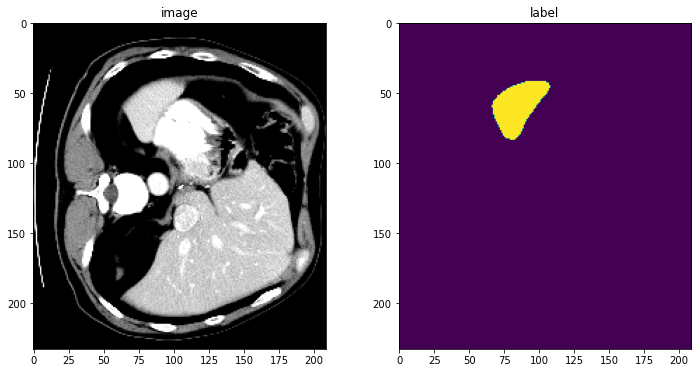

In [15]:
check_ds = Dataset(data=test_demo_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot only the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Model training 

+ Separately store the dataset into training and testing
+ Upload the dataset into S3 
+ SageMaker training job

In [16]:
prefix="MONAI_Segmentation"

processed_train_path = os.path.join(data_dir,"processed","train")
processed_test_path = os.path.join(data_dir,"processed","test")

processed_train_images_path = os.path.join(processed_train_path, "imagesTr")
processed_train_labels_path = os.path.join(processed_train_path, "labelsTr")

processed_test_images_path = os.path.join(processed_test_path, "imagesTr")
processed_test_labels_path = os.path.join(processed_test_path, "labelsTr")

Path(processed_train_images_path).mkdir(parents=True, exist_ok=True)
Path(processed_train_labels_path).mkdir(parents=True, exist_ok=True)
print("Directory '%s' created" %processed_train_path)

Path(processed_test_images_path).mkdir(parents=True, exist_ok=True)
Path(processed_test_labels_path).mkdir(parents=True, exist_ok=True)
print("Directory '%s' created" %processed_test_path)

Directory 'Spleen3D/processed/train' created
Directory 'Spleen3D/processed/test' created


In [17]:
## copy dataset for training 
for file in train_files:
    images = file["image"]
    images_dest = processed_train_images_path
    label = file["label"]
    label_dest = processed_train_labels_path
    shutil.copy(images,images_dest)
    shutil.copy(label,label_dest)

In [18]:
## copy dataset for testing 
for file in test_demo_files:
    images = file["image"]
    images_dest = processed_test_images_path
    label = file["label"]
    label_dest = processed_test_labels_path
    shutil.copy(images,images_dest)
    shutil.copy(label,label_dest)

### Upload datasets to S3

In [19]:
## upload training dataset to S3
S3_inputs = sess.upload_data(
    path=processed_train_path,
    key_prefix=f"{prefix}/train",
    bucket=bucket 
)



In [20]:
## upload testing dataset to S3
S3_demo_test = sess.upload_data(
    path=processed_test_images_path,
    key_prefix=f"{prefix}/demo_test",
    bucket=bucket 
)

### SageMaker training job

In [21]:
%%time

metrics=[
   {"Name": "train:average epoch loss", "Regex": "average loss: ([0-9\\.]*)"},
   {"Name": "train:current mean dice", "Regex": "current mean dice: ([0-9\\.]*)"},
   {"Name": "train:best mean dice", "Regex": "best mean dice: ([0-9\\.]*)"}
]

estimator = PyTorch(source_dir="code",
                    entry_point="train.py",
                    role=role,
                    framework_version="1.6.0",
                    py_version="py3",
                    instance_count=1,
#                     instance_type="ml.p2.xlarge",
                    instance_type="ml.g4dn.2xlarge",
                    hyperparameters={
                       "seed": 123,
                       "lr": 0.001,
                       "epochs": 20
                    },
                    metric_definitions=metrics,
#                     ### spot instance training ###
#                    use_spot_instances=True,
#                     max_run=2400,
#                     max_wait=2400
                )


estimator.fit(S3_inputs)

2022-07-21 06:07:22 Starting - Starting the training job...
2022-07-21 06:07:48 Starting - Preparing the instances for trainingProfilerReport-1658383641: InProgress
.........
2022-07-21 06:09:20 Downloading - Downloading input data
2022-07-21 06:09:20 Training - Downloading the training image..............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-21 06:11:29,243 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-21 06:11:29,264 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-21 06:11:29,279 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-21 06:11:29,605 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install -r requirements.txt
  Installing build dependencies: started
  Installing build dependencies: finished wi

## Inference 

+ Deploy the model with customized inference script and trained estimator - model artifact in S3.
+ Inference with testing image in S3
+ Visualize the results

The endpoint will return two types of output. If an integer is provided for the slice number, it will return the inference result for that slice. If "start slice" and "end slice" are provided or if the input provided is "all" - referring to all slices, it will return the S3 location where the inference result is saved.

Demonstrated in this notebook:
1. Inference for multiple slices by looping the endpoint API calls
2. Inference across multiple images and slices using loops
3. Perform inference on a selection of slices
4. Perform inference on all slices

### Create endpoint

In [22]:
## realtime endpoint

predictor = estimator.deploy(
    initial_instance_count=1,
    source_dir="code",
    entry_point="inference.py", 
    instance_type="ml.m5.4xlarge",
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

-------!

### Inference for multiple slices by looping the endpoint API calls

In [23]:
prefix

'MONAI_Segmentation'

In [24]:
test_demo_files[0]["image"]

'Spleen3D/datasets/Task09_Spleen/imagesTr/spleen_9.nii.gz'

In [25]:
prefix_key = f"{prefix}/demo_test"
file = test_demo_files[0]["image"].split("/")[-1]
print(file)

spleen_9.nii.gz


In [26]:
### run either this cell or the next, 
### depending on whether you want to loop from slice 0 to "totalslice" 
### or only a small set of slices using "nslicestart" and "nsliceend"

###Option 1 - use totalslice

### use only one of the below two lines

####Option 1a
# totalslice = np.array(image).shape[-1] #use this if you want to perform inference on all slices in an image
####Option 1b
# totalslice = 30 #use this if you want to perform inference for a set number slices starting from index 0 

# print(f"Total slices = {totalslice}")
# nslice = 50 #must be at least 1 less than "totalslice"
# nslicestart = 0 #set to 0 for consistency in the visualization cell

In [27]:
###Option 2 - use "nslicestart" and "nsliceend"

nslicestart=50
nsliceend=55
nslice=0

In [28]:
%%time
test_demo_preds=[]

###Option 1 - use totalslice
# for counter in range(totalslice): #for using totalslice

###Option 2 - use "nslicestart" and "nsliceend"
for counter in range(int(nslicestart),int(nsliceend)): #for using "slicestart" and "sliceend"
    payload={
        "bucket": bucket,
        "key": prefix_key,
        "file": file,
        "nslice": counter
            }
    response_pred=predictor.predict(payload)
    print("inference for slice",counter)
    test_demo_preds.append(response_pred)

inference for slice 50
inference for slice 51
inference for slice 52
inference for slice 53
inference for slice 54
CPU times: user 65.2 ms, sys: 0 ns, total: 65.2 ms
Wall time: 43.1 s


In [29]:
test_demo_ds = check_ds
test_demo_loader = check_loader
test_demo_data = check_data

In [30]:
torch.tensor(test_demo_preds[nslice]["pred"]).size()

torch.Size([233, 209])

### Visualize the result for 1 slice

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


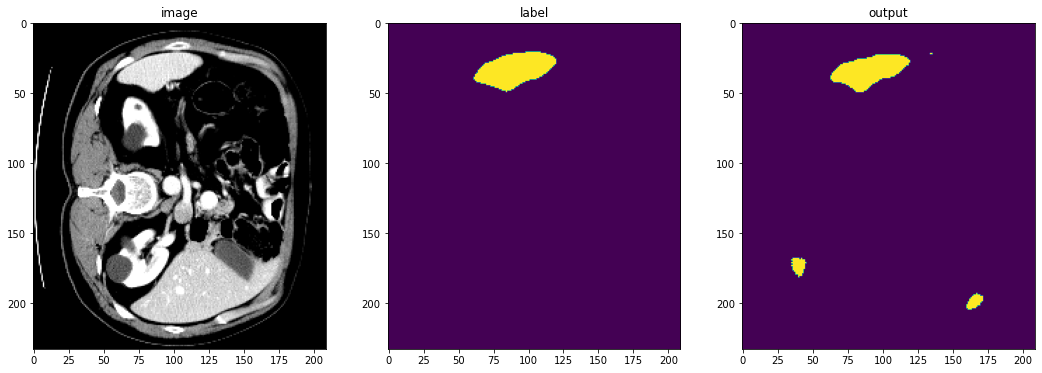

In [31]:
image, label = (test_demo_data["image"][0][0], test_demo_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# Visualization
# plot the slice [:, :, nslice]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(test_demo_data["image"][0, 0, :, :, nslicestart+nslice], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(test_demo_data["label"][0, 0, :, :, nslicestart+nslice])
plt.subplot(1, 3, 3)
plt.title("output")
plt.imshow(test_demo_preds[nslice]["pred"])

plt.show()

## Clean up the resources

+ delete the current endpoint or all the endpoints to save cost

In [35]:
predictor.delete_predictor(delete_endpoint_config=True)